## 4.3 分类分析-案例：用户流失预测分析与应用

In [2]:
# 导入库
import pandas as pd
from sklearn.model_selection import train_test_split  # 数据分区库
import xgboost as xgb
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, \
    precision_score, recall_score, roc_curve  # 导入指标库
from imblearn.over_sampling import SMOTE  # 过抽样处理库SMOTE
import matplotlib.pyplot as plt
import prettytable  # 导入表格库

Using TensorFlow backend.


In [3]:
# 读取准备
raw_data = pd.read_csv('./data/classification.csv', delimiter=',')  # 读取数据文件
X,y = raw_data.iloc[:, :-1],raw_data.iloc[:, -1]  # 分割X,y

In [4]:
# 数据基本审查
n_samples, n_features = X.shape  # 总样本量,总特征数
print('samples: {0}| features: {1} | na count: {2}'.format(n_samples, n_features,raw_data.isnull().any().count()))

samples: 1000| features: 41 | na count: 42


In [5]:
# 数据预处理
# 填充缺失值
X = X.fillna(X.mean())
# 样本均衡处理
#'''
model_smote = SMOTE()  # 建立SMOTE模型对象
X, y = model_smote.fit_sample(X,y)  # 输入数据并作过抽样处理
#'''

In [6]:
# 拆分数据集
X = pd.DataFrame(X,columns=raw_data.columns[:-1])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=0)  # 将数据分为训练集和测试集

In [7]:
# XGB分类模型训练
param_dist = {'objective': 'binary:logistic', 'n_estimators': 10,
              'subsample': 0.8, 'max_depth': 10, 'n_jobs': -1}
model_xgb = xgb.XGBClassifier(**param_dist)
model_xgb.fit(X_train, y_train)
pre_y = model_xgb.predict(X_test)

In [8]:
# 混淆矩阵
tn, fp, fn, tp = confusion_matrix(y_test, pre_y).ravel()  # 获得混淆矩阵
confusion_matrix_table = prettytable.PrettyTable(['','prediction-0','prediction-1'])  # 创建表格实例
confusion_matrix_table.add_row(['actual-0',tp,fn])  # 增加第一行数据
confusion_matrix_table.add_row(['actual-1',fp,tn])  # 增加第二行数据
print('confusion matrix \n',confusion_matrix_table)

confusion matrix 
 +----------+--------------+--------------+
|          | prediction-0 | prediction-1 |
+----------+--------------+--------------+
| actual-0 |     185      |      29      |
| actual-1 |      60      |     162      |
+----------+--------------+--------------+


In [9]:
# 核心评估指标
y_score = model_xgb.predict_proba(X_test)  # 获得决策树的预测概率
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])  # ROC
auc_s = auc(fpr, tpr)  # AUC
scores = [round(i(y_test, pre_y),3 )for  i in (accuracy_score,precision_score,\
                                     recall_score,f1_score)]
scores.insert(0,auc_s)
core_metrics = prettytable.PrettyTable()  # 创建表格实例
core_metrics.field_names = ['auc', 'accuracy', 'precision', 'recall', 'f1']  # 定义表格列名
core_metrics.add_row(scores)  # 增加数据
print('core metrics\n',core_metrics)

core metrics
 +--------------------+----------+-----------+--------+-------+
|        auc         | accuracy | precision | recall |   f1  |
+--------------------+----------+-----------+--------+-------+
| 0.8660646627936348 |  0.796   |   0.755   | 0.864  | 0.806 |
+--------------------+----------+-----------+--------+-------+


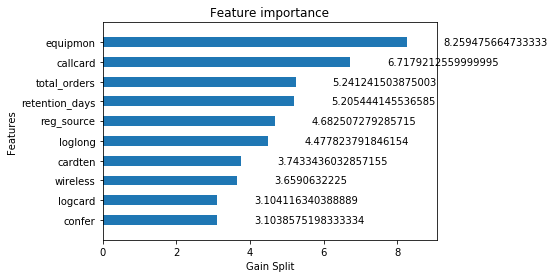

In [10]:
# 输出特征重要性
xgb.plot_importance(model_xgb,height=0.5,importance_type='gain',max_num_features=10,xlabel='Gain Split',grid=False) 

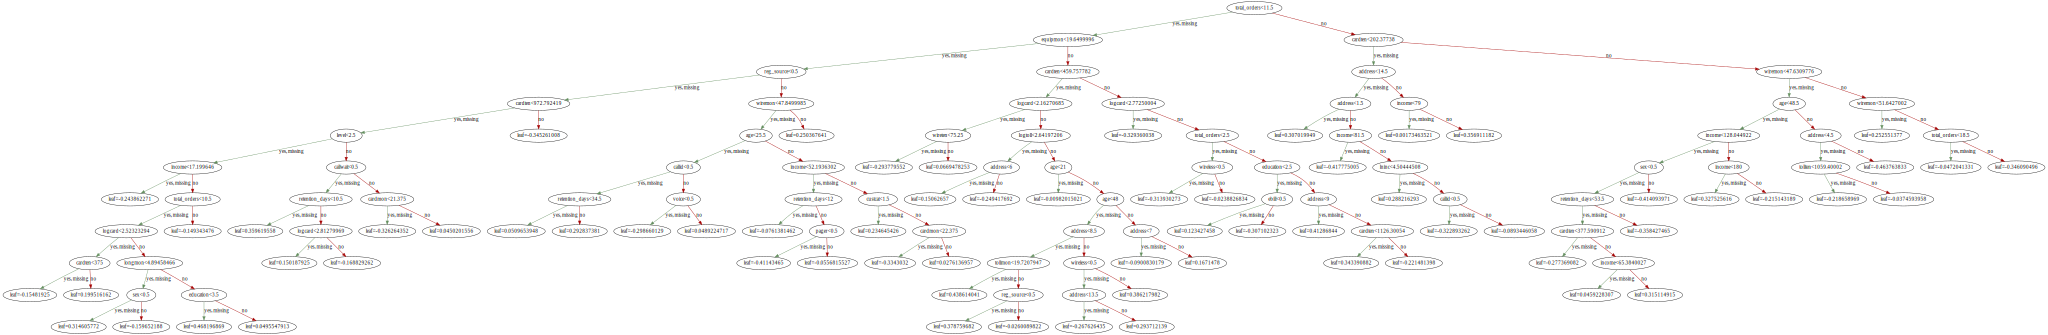

In [11]:
# 输出树形规则图
xgb.to_graphviz(model_xgb, num_trees=1, yes_color='#638e5e', no_color='#a40000') 

In [12]:
# 前N条规则对应的用户数据
rule_depth_1 = X_test['internet']<0.00284512946
rule_depth_2 = X_test['longten']<230.75
rule_depth_3 = X_test['total_orders']<2.97253799
rule_depth_4 = X_test['sex']<0.972537994
rule_depth_5 = X_test['wireten']<86.0607376
rule_list = [rule_depth_1,rule_depth_2,rule_depth_3,rule_depth_4,rule_depth_5]
rule_pd = [pd.DataFrame(i) for i in rule_list]
rule_pd_merge = pd.concat(rule_pd,axis=1)

# 遍历不同条件下用户的情况
for i in range(5):
    dyn_rules = rule_pd_merge.iloc[:,:i+1] # 取出top规则
    dyn_rules['is_true']=[all(i)==True for i in dyn_rules.values]# 得到都为true的record
    y_test_selected = y_test[dyn_rules['is_true']]
    y_pre_selected = y_score[dyn_rules['is_true']]
    y_pre_cal = y_pre_selected[:,1] >=0.5
    total_samples = len(y_pre_cal)
    is_churn = y_pre_cal.sum()
    churn_rate = float(is_churn)/total_samples
    # 计算样本比例
    print('total samples: {}'.format(total_samples))
    print('churn samples: {} | rate: {:.0%} '.format(is_churn,churn_rate))
    print('unchurn samples: {} | rate: {:.0%} '.format((total_samples-is_churn),(1-churn_rate)))
    print('-'*40)

total samples: 266
churn samples: 128 | rate: 48% 
unchurn samples: 138 | rate: 52% 
----------------------------------------
total samples: 126
churn samples: 87 | rate: 69% 
unchurn samples: 39 | rate: 31% 
----------------------------------------
total samples: 48
churn samples: 39 | rate: 81% 
unchurn samples: 9 | rate: 19% 
----------------------------------------
total samples: 33
churn samples: 28 | rate: 85% 
unchurn samples: 5 | rate: 15% 
----------------------------------------
total samples: 27
churn samples: 22 | rate: 81% 
unchurn samples: 5 | rate: 19% 
----------------------------------------


c:\cx\python\python36\installthere\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
